### Multivariate time series prediction using MLP (Advanced version)

This is continuation of the MLP model we saw before.

Architecturally it's similar to the last model. Except it implements dropout for regularization.

**A dropout layer in a neural network randomly sets a percentage of input units to zero during training, which helps prevent overfitting and improves the model's ability to generalize to new data. By default the probability of dropout is 50%. Dropout is usually applied after the activation layer.**

Another thing we do differently here is we implement the model to utilize GPU if it's available. 

Similarly, we also implement early stopping. Early stopping is a technique where the model stops training when it stops improving. This is done by calculating loss against the validation data. If the loss stops to improve, we stop training. We save the model with the least validation loss and load it after stopping the training process. This is done to stop overfitting of the model to the training data. Validation data should be different from the training data.


This notebooks implements MLP with **regularization and early stopping** with model implemented to fully use **GPU**.

In [1]:
import torch
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
path = '../dataset/final_data.csv'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cuda


Here we define **RiverData** a custom Dataset class to load the dataset we have. It extends the pytorch Dataset class.  
- We need to define \_\_init__() function which can be used for loading data from file and optionally for data preprocessing.
- Thereafter we define \_\_len__() function which gives the length of dataset.
- Then we define \_\_getitem__() function which returns an instance of (feature, label) tuple which can be used for model training.
  For our time series data, feature means the past values to be used for training and label means the future values to be predicted.

In [4]:
class RiverData(torch.utils.data.Dataset):
    
    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()
        

    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)
    

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature.T, label) 

### Normalize the data

In [5]:
df = pd.read_csv(path)
df = df[df['DATE'] > '2012']

raw_df = df.drop('DATE', axis=1, inplace=False)
scaler = MinMaxScaler()

# Apply the transformations
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns=raw_df.columns)
df_scaled['DATE'] = df['DATE']
df = df_scaled

Some advanced python syntax have been used here. \
*common_args : it's used to pass arguments to a function, where common_args represents a python list \
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [6]:

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 13
pred_len = 1
num_features = 7

common_args = ['gauge_height', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)


In [7]:
# Important parameters

BATCH_SIZE = 512 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load


In [8]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

### Here we define our pytorch model.

BasicMLPNetwork is the model class, it extends the Module class provided by pytorch. \
- We define \_\_init__() function. It sets up layers and defines the model parameters.
- Also, we define forward() function which defines how the forwared pass computation occurs

In [9]:
# Here we are adding dropout layers.

class BasicMLPNetwork(torch.nn.Module):
    
    def __init__(self, seq_len, pred_len, num_features, dropout):
        # call the constructor of the base class
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features
        hidden_size_time = 256
        hidden_size_feat = 128
        # define layers for combining across time series
        self.fc1 = torch.nn.Linear(self.seq_len, hidden_size_time)
        self.relu = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.fc2 = torch.nn.Linear(hidden_size_time, self.pred_len)
        self.dropout2 = torch.nn.Dropout(p=dropout)

        # define layers for combining across the features
        self.fc3 = torch.nn.Linear(self.num_features, hidden_size_feat)
        self.fc4 = torch.nn.Linear(hidden_size_feat, 1)

    def forward(self, x):

        # computation over time
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out) # has dimension 512 x 7 x 12
        out = self.dropout2(out)
        # computation over features
        out = out.transpose(1,2) # dimension 512 x 12 x 7
        out = self.fc3(out) # dimension 512 x 12 x 20
        out = self.relu(out)
        out = self.fc4(out) # dimension 512 x 12 x 1

        out = out.squeeze(-1) # dimension 512 x 12
        
        return out

# Note that the gradients are stored insize the FC layer objects
# For each training example we need to get rid of these gradients

In [10]:
dropout_p = 0.063844
learning_rate = 0.000286122368
weight_decay = 0.0001111917  # Regularization strength

model = BasicMLPNetwork(seq_len, pred_len, num_features, dropout_p)
model = model.to(device)
loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [11]:
for gen in model.parameters():
    print(gen.shape)

torch.Size([256, 13])
torch.Size([256])
torch.Size([1, 256])
torch.Size([1])
torch.Size([128, 7])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])


In [12]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([512, 7, 13])
labels shape:  torch.Size([512, 1])


In [26]:
# define metrics
import numpy as np
import matplotlib.pyplot as plt

epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaulation mode. It disables dropout and batch normalization if they have 
    # are part of the model. For our simple model it's not necessary. Still I'm going to use it.

    model.eval()
    all_inputs = torch.empty((0, num_features, seq_len))
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        all_inputs = torch.vstack((all_inputs, inputs))
        all_labels = torch.vstack((all_labels, labels))
    
    with torch.no_grad():
        all_inputs = all_inputs.to(device)
        outputs = model(all_inputs).detach().cpu()
        avg_val_loss = loss(outputs, all_labels)
        nse = nse_function(all_labels.numpy(), outputs.numpy())
        wape = wape_function(all_labels.numpy(), outputs.numpy())
        
    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    model.train()

    if plot:
        plt.plot(np.array(all_labels.cpu()[:100]), color='green', label='observations')
        plt.plot(np.array(outputs.cpu()[:100]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}" 
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.show()
    
    return avg_val_loss


In [22]:
num_epochs = 200
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
    avg_val_loss = evaluate_model(model, val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best model before stopping
            model.load_state_dict(torch.load('best_model.pth'))
            break

Epoch 1: Traning Loss: 0.0020693597350982113 NSE : 0.9513643346726894 WAPE : 10.364876585830594 Validation Loss: 0.0006414607050828636
Epoch 2: Traning Loss: 0.001958963323318893 NSE : 0.9505114629864693 WAPE : 10.52710611055952 Validation Loss: 0.0006527093355543911
Epoch 3: Traning Loss: 0.0019044062058635107 NSE : 0.9541256576776505 WAPE : 10.066836682317648 Validation Loss: 0.0006050413940101862
Epoch 4: Traning Loss: 0.001998072935150305 NSE : 0.9586677812039852 WAPE : 9.420530019873645 Validation Loss: 0.0005451348843052983
Epoch 5: Traning Loss: 0.0019510440746573856 NSE : 0.9474613629281521 WAPE : 10.923336025408418 Validation Loss: 0.0006929374067112803
Epoch 6: Traning Loss: 0.001954198598896072 NSE : 0.9550940655171871 WAPE : 9.99149639919048 Validation Loss: 0.000592268945183605
Epoch 7: Traning Loss: 0.001953648477218476 NSE : 0.9521582387387753 WAPE : 10.409817839283008 Validation Loss: 0.0006309898453764617
Epoch 8: Traning Loss: 0.0019737283783010052 NSE : 0.95275959372

NSE : 0.9339142590761185 WAPE : 14.09186860006294 Validation Loss: 0.0007374454871751368


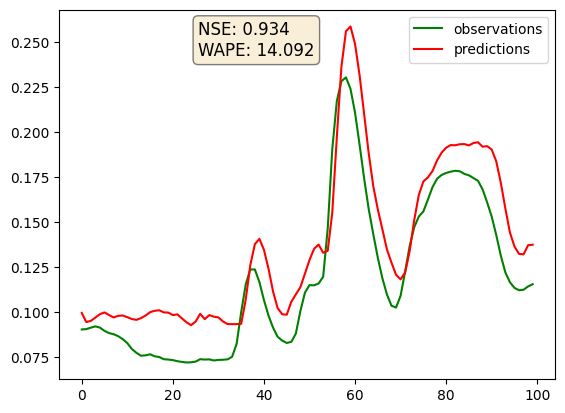

tensor(0.0007)

In [27]:
evaluate_model(model, test_loader, True)